In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.0 MB/s eta 0:00:00


In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

GPU is available!
Device: cuda


In [3]:

from google.colab import files
files.upload()

#jupytext --to ipynb Comparative_Cheb_GCN.py
!unzip numpy_data.zip


Saving numpy_data.zip to numpy_data.zip
Archive:  numpy_data.zip
  inflating: AdjacencyMatrix.npy     
  inflating: new_data.npy            
  inflating: new_labels.npy          
  inflating: NodeIndex.npy           


Comparative Chebyshev GCN

In [4]:

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import torch
import networkx as nx
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
print(os.getcwd())

2.4.1+cu121
/content


In [5]:
import time
#Extract Training Data

path = os.getcwd()

numpy_data = np.load(path+"/new_data.npy",allow_pickle = True)
numpy_data = np.squeeze(numpy_data)
print(numpy_data)
print(numpy_data.shape)
print(numpy_data.size)

value_data = np.load(path+"/new_labels.npy",allow_pickle = True)
print(value_data)
print(value_data.shape)
print(value_data.size)


NodeIndex = np.load(path+"/NodeIndex.npy",allow_pickle = True)
print(NodeIndex)
print(NodeIndex.shape)
print(NodeIndex.size)

AdjacencyMatrix = np.load(path+"/AdjacencyMatrix.npy",allow_pickle = True)
print(AdjacencyMatrix)
print(AdjacencyMatrix.shape)
print(AdjacencyMatrix.size)

[[[52.7097 -75.9 52.7097 164.1 52.7097 44.1]
  [52.709 -75.9 52.7092 164.1 52.7092 44.1]
  [52.7087 -75.9 52.7089 164.1 52.7089 44.1]
  ...
  [0.106712 -107.9 0.106748 132.1 0.106717 12.1]
  [0.104521 -109.5 0.104336 130.4 0.104066 10.6]
  [0.10452 -109.5 0.104335 130.4 0.104065 10.6]]

 [[85214.3 -7.3 500115.0 -33.9 416832.0 -5.1]
  [211.546 -91.2 462267.0 -36.1 379804.0 -4.7]
  [211.568 -91.1 462266.0 -36.1 379804.0 -4.7]
  ...
  [454.247 176.4 552.921 -35.0 288.794 90.0]
  [450.326 175.5 548.222 -35.9 286.192 89.1]
  [450.325 175.5 548.221 -35.9 286.191 89.1]]

 [[139420.0 0.0 138954.0 -120.1 139023.0 120.1]
  [139419.0 0.0 138921.0 -120.1 138988.0 120.1]
  [139419.0 0.0 138914.0 -120.1 138980.0 120.1]
  ...
  [252.616 -12.5 255.72 -169.3 102.452 87.5]
  [250.213 -13.6 254.539 -169.7 104.581 86.1]
  [250.529 -13.0 253.277 -170.0 100.968 87.1]]

 ...

 [[138947.0 0.0 138946.0 -120.0 138948.0 120.0]
  [138908.0 0.0 138910.0 -120.0 138911.0 120.0]
  [138899.0 0.0 138902.0 -120.0 138903

In [6]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import NormalizeFeatures
from torch.nn.functional import normalize

encoder = ['P1', 'P2', 'P3', 'P7', 'P6', 'P11', 'P27', 'P44', 'P45', 'P62', 'P10',
        'P81', 'P97', 'P116', 'P117', 'P134', 'P12', 'P13', 'P14', 'P15', 'P16',
        'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P28',
        'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39',
        'P40', 'P41', 'P42', 'P43', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52',
        'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P63', 'P64',
        'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75',
        'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83', 'P84', 'P85', 'P86', 'P87',
        'P88', 'P89', 'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P96', 'P98', 'P99',
        'P100', 'P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
        'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P118', 'P119', 'P120', 'P121',
        'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128', 'P129', 'P130', 'P131',
        'P132', 'P133', 'P135', 'P136', 'P137', 'P138', 'P139', 'P140', 'P141', 'P142',
        'P143', 'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P150', 'S194', 'S193',
        'S195', 'S199', 'S198', 'S200', 'S204', 'S203', 'S205', 'S206', 'S211', 'S210',
        'S212', 'S213', 'S218', 'S217', 'S219', 'S220', 'S225', 'S224', 'S226', 'S227',
        'S232', 'S231', 'S233', 'S237', 'S236', 'S239', 'S1', 'S2', 'S3', 'S4', 'S5',
        'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17',
        'S18', 'S19', 'S20', 'S21', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48',
        'S49', 'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59',
        'S60', 'S61', 'S62', 'S83', 'S84', 'S85', 'S86', 'S87', 'S88', 'S89', 'S90',
        'S91', 'S92', 'S93', 'S94', 'S95', 'S96', 'S97', 'S98', 'S99', 'S100', 'S101',
        'S102', 'S103', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S131',
        'S132', 'S133', 'S134', 'S135', 'S136', 'S137', 'S138', 'S139', 'S140', 'S141',
        'S142', 'S143', 'S144', 'S22', 'S27', 'S32', 'S37', 'S63', 'S68', 'S73', 'S78',
        'S104', 'S109', 'S114', 'S119', 'S23', 'S28', 'S33', 'S38', 'S64', 'S69', 'S74',
        'S79', 'S105', 'S110', 'S115', 'S120', 'S24', 'S29', 'S34', 'S39', 'S65', 'S70',
        'S75', 'S80', 'S106', 'S111', 'S116', 'S121', 'S25', 'S30', 'S35', 'S40', 'S66',
        'S71', 'S76', 'S81', 'S107', 'S112', 'S117', 'S122', 'S26', 'S31', 'S36', 'S41',
        'S67', 'S72', 'S77', 'S82', 'S108', 'S113', 'S118', 'S123', 'P4', 'P5', 'P8',
        'P9', 'S148', 'S145', 'S152', 'S149', 'S156', 'S153', 'S160', 'S157', 'S147',
        'S146', 'S151', 'S150', 'S155', 'S154', 'S159', 'S158', 'S164', 'S161', 'S168',
        'S165', 'S172', 'S169', 'S176', 'S173', 'S163', 'S162', 'S167', 'S166', 'S171',
        'S170', 'S175', 'S174', 'S180', 'S177', 'S184', 'S181', 'S188', 'S185', 'S192',
        'S189', 'S179', 'S178', 'S183', 'S182', 'S187', 'S186', 'S191', 'S190', 'S196',
        'S197', 'S201', 'S202', 'S207', 'S208', 'S209', 'S214', 'S215', 'S216', 'S221',
        'S222', 'S223', 'S228', 'S229', 'S230', 'S234', 'S235', 'S238', 'S240']
#encoder = ['SourceBus', '800', '802', '806', '808', '810', '812', '814', '814r', '850',
#'816', '818', '824', '820', '822', '826', '828', '830', '854', '832', '858',
#'834', '860', '842', '836', '840', '862', '844', '846', '848', '852r', '888', '856', '852', '864', '838', '890']
print(encoder)

research_paper_decoder = [0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 3, 9, 10, 11, 12, 13, 4, 14, 15, 14, 16,
                          17, 14, 18, 14, 19, 20, 14, 21, 14, 22, 5, 14, 23, 14, 24, 14, 25, 14,
                          26, 14, 27, 14, 28, 29, 14, 30, 7, 14, 31, 14, 32, 14, 33, 14, 34, 35,
                          36, 14, 37, 14, 38, 39, 8, 14, 40, 14, 41, 14, 42, 14, 43, 14, 44, 45,
                          14, 46, 14, 47, 14, 48, 9, 14, 49, 14, 50, 51, 14, 52, 14, 53, 54, 14,
                          55, 14, 56, 10, 14, 57, 14, 58, 14, 59, 14, 60, 61, 14, 62, 14, 63, 14,
                          64, 14, 65, 12, 14, 66, 14, 67, 14, 68, 14, 69, 14, 70, 14, 71, 72, 14,
                          73, 13, 14, 74, 14, 75, 76, 14, 77, 14, 78, 79, 80, 14, 81, 14, 82, 29,
                          83, 63, 39, 84, 72, 20, 85, 45, 78, 46, 86, 54, 80, 25, 87, 35, 61, 34,
                          88, 59, 68, 42, 89, 75, 16, 90, 51, 91, 92, 93, 73, 94, 95, 96, 97, 56,
                          98, 99, 100, 101, 38, 102, 103, 104, 105, 22, 106, 107, 108, 109, 55, 70,
                          110, 111, 112, 81, 44, 113, 114, 115, 21, 79, 116, 117, 118, 47, 27, 119,
                          120, 121, 122, 36, 74, 123, 124, 125, 77, 32, 126, 127, 128, 18, 58, 129,
                          130, 131, 33, 76, 132, 133, 134, 135, 40, 136, 137, 138, 139, 31, 140,
                          141, 142, 143, 23, 144, 145, 146, 147, 24, 148, 149, 150, 151, 82, 152,
                          153, 154, 62, 155, 156, 157, 17, 158, 159, 160, 65, 64, 161, 162, 19, 69,
                          163, 164, 67, 66, 165, 166, 48, 71, 167, 168, 53, 60, 169, 170, 50, 57,
                          171, 172, 30, 28, 173, 174, 52, 26, 175, 176, 15, 41, 177, 178, 179, 37,
                          180, 181, 182, 43, 183, 184, 185, 49, 186, 2, 2, 3, 3, 82, 73, 65, 56,
                          48, 38, 30, 22, 55, 64, 81, 71, 21, 28, 47, 37, 62, 70, 19, 44, 53, 79,
                          52, 27, 36, 69, 77, 60, 18, 26, 33, 43, 17, 74, 67, 32, 50, 58, 15, 76,
                          40, 66, 31, 57, 23, 41, 24, 49, 29, 63, 39, 72, 20, 45, 78, 46, 54, 80,
                          25, 35, 61, 34, 59, 68, 42, 75, 16, 51]

# Previous Encoding
# research_paper_decoder = [0, 1, 2, 3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 4, 15, 16, 15,
#                           17, 18, 19, 20, 19, 21, 22, 23, 24, 23, 25, 5, 15, 26, 15, 27, 19,
#                           28, 19, 29, 19, 30, 23, 31, 32, 23, 33, 7, 34, 35, 34, 36, 34, 37,
#                           38, 39, 40, 41, 42, 43, 42, 44, 45, 8, 34, 46, 34, 47, 34, 48, 38,
#                           49, 38, 50, 51, 38, 52, 42, 53, 42, 54, 10, 55, 56, 55, 57, 58, 59,
#                           60, 59, 61, 62, 63, 64, 63, 65, 11, 55, 66, 55, 67, 59, 68, 59, 69,
#                           70, 59, 71, 63, 72, 63, 73, 63, 74, 13, 75, 76, 75, 77, 75, 78, 79,
#                           80, 79, 81, 82, 83, 84, 82, 85, 14, 75, 86, 75, 87, 88, 79, 89, 79,
#                           90, 91, 92, 82, 93, 82, 94, 32, 95, 72, 45, 96, 84, 22, 97, 51, 90,
#                           52, 98, 62, 92, 28, 99, 40, 70, 39, 100, 68, 78, 48, 101, 87, 17,
#                           102, 58, 103, 104, 105, 85, 106, 107, 108, 109, 65, 110, 111, 112,
#                           113, 44, 114, 115, 116, 117, 25, 118, 119, 120, 121, 64, 81, 122,
#                           123, 124, 93, 50, 125, 126, 127, 24, 91, 128, 129, 130, 53, 30, 131,
#                           132, 133, 134, 41, 86, 135, 136, 137, 89, 36, 138, 139, 140, 20, 67,
#                           141, 142, 143, 37, 88, 144, 145, 146, 147, 46, 148, 149, 150, 151, 35,
#                           152, 153, 154, 155, 26, 156, 157, 158, 159, 27, 160, 161, 162, 163, 94,
#                           164, 165, 166, 71, 167, 168, 169, 18, 170, 171, 172, 74, 73, 173, 174,
#                           21, 80, 175, 176, 77, 76, 177, 178, 54, 83, 179, 180, 61, 69, 181, 182,
#                           57, 66, 183, 184, 33, 31, 185, 186, 60, 29, 187, 188, 16, 47, 189, 190,
#                           191, 43, 192, 193, 194, 49, 195, 196, 197, 56, 198, 2, 2, 3, 3, 94, 85,
#                           74, 65, 54, 44, 33, 25, 64, 73, 93, 83, 24, 31, 53, 43, 71, 81, 21, 50,
#                           61, 91, 60, 30, 41, 80, 89, 69, 20, 29, 37, 49, 18, 86, 77, 36, 57, 67,
#                           16, 88, 46, 76, 35, 66, 26, 47, 27, 56, 32, 72, 45, 84, 22, 51, 90, 52,
#                           62, 92, 28, 40, 70, 39, 68, 78, 48, 87, 17, 58]

# Oldest Encoding
# research_paper_decoder = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 5, 16, 17,
#                           18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 6, 30, 31, 32, 33,
#                           34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 8, 45, 46, 47, 48, 49,
#                           50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 9, 60, 61, 62, 63, 64, 65,
#                           66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 11, 77, 78, 79, 80, 81,
#                           82, 83, 84, 85, 86, 87, 88, 89, 90, 12, 91, 92, 93, 94, 95, 96, 97,
#                           98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 14, 108, 109, 110,
#                           111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 15, 123,
#                           124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
#                           42, 138, 103, 59, 139, 120, 25, 140, 70, 131, 72, 141, 86, 133, 35,
#                           142, 53, 99, 52, 143, 96, 113, 65, 144, 126, 19, 145, 81, 146, 147,
#                           148, 122, 149, 150, 151, 152, 90, 153, 154, 155, 156, 58, 157, 158,
#                           159, 160, 29, 161, 162, 163, 164, 88, 117, 165, 166, 167, 135, 69,
#                           168, 169, 170, 27, 132, 171, 172, 173, 74, 39, 174, 175, 176, 177,
#                           54, 124, 178, 179, 180, 129, 48, 181, 182, 183, 22, 94, 184, 185,
#                           186, 50, 127, 187, 188, 189, 190, 61, 191, 192, 193, 194, 46, 195,
#                           196, 197, 198, 31, 199, 200, 201, 202, 33, 203, 204, 205, 206, 137,
#                           207, 208, 209, 101, 210, 211, 212, 20, 213, 214, 215, 107, 105, 216,
#                           217, 24, 115, 218, 219, 111, 109, 220, 221, 76, 119, 222, 223, 85, 98,
#                           224, 225, 80, 92, 226, 227, 44, 41, 228, 229, 83, 37, 230, 231, 17, 63,
#                           232, 233, 234, 56, 235, 236, 237, 67, 238, 239, 240, 78, 241, 2, 2, 3, 3,
#                           137, 122, 107, 90, 76, 58, 44, 29, 88, 105, 135, 119, 27, 41, 74, 56, 101,
#                           117, 24, 69, 85, 132, 83, 39, 54, 115, 129, 98, 22, 37, 50, 67, 20, 124, 111,
#                           48, 80, 94, 17, 127, 61, 109, 46, 92, 31, 63, 33, 78, 42, 103, 59, 120, 25,
#                           70, 131, 72, 86, 133, 35, 53, 99, 52, 96, 113, 65, 126, 19, 81]

#research_paper_decoder = [0,0,0,1,2,3,4,5,6,7,8,9,10,11,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,72,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,14,11,61,61,63,119]
print(research_paper_decoder)
print(len(research_paper_decoder))
FaultLocationLabels = value_data[:,3]
#
for n in range(len(FaultLocationLabels)):
    FaultLocationLabels[n]=research_paper_decoder[encoder.index(str(FaultLocationLabels[n]))]
#
y = FaultLocationLabels.astype("int64")
y = torch.from_numpy(y)
x = numpy_data.astype("float32")
x = torch.from_numpy(x)
#
NodeIndex = NodeIndex.astype("int64")
NodeIndex = NodeIndex.T
NodeIndex = torch.from_numpy(NodeIndex)
#
print(y)
print(y.dtype)
print(x)
print(x.dtype)
print(NodeIndex)
print(NodeIndex.dtype)
##
#print(x[0])
#print(normalize(x[0]))
#
result_translator = np.unique(FaultLocationLabels.astype("int64")).tolist()
print()
total_data_list = []
for n in range(len(x)):
    #print(x[n])
    #print(y[n])
    DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True) #Testing with non-normalized data
    #DataObject = Data(x = x[n], edge_index = NodeIndex, y = y[n], is_undirected = True)
    DataObject.is_undirected = True
    total_data_list.append(DataObject)
print('Y'*888)
print(total_data_list[0].x)

print()
#print(f'Dataset: {total_data_list}:')
print('===================')
print(f'Number of graphs: {len(total_data_list)}')
print(f'Number of features: {total_data_list[0].num_features}')
##print(f'Number of classes: {total_data_list[0].num_classes}')
#
data = total_data_list[0]  # Get the first graph object.

print()
print(NormalizeFeatures(data.x))
print(data.x)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

from random import shuffle
torch.manual_seed(12345)
#total_data_list = total_data_list.shuffle()
shuffle(total_data_list)

train_dataset = total_data_list[:24960]
test_dataset = total_data_list[24960:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')


print(test_dataset[0].x)
print(test_dataset[0])
print(train_dataset[0].x)
#
for sample in range(len(test_dataset)):
    #noise = np.random.normal(1,0.03, size = (37,6)) #0.09

    #Uncomment for noise
    # noise = np.random.normal(1,0.03, size = (390,6)) #0.09
    # noise = noise.astype("float32")
    # noise = torch.from_numpy(noise)
    # test_dataset[sample].x = noise*test_dataset[sample].x
    test_dataset[sample].x = normalize(test_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(test_dataset[0].x)
print(test_dataset[0])
##noise = np.random.normal(1,0.09, size = (16,6))
##noise = noise.astype("float32")
##noise = torch.from_numpy(noise)
print('=============================================================')
###
#print(train_dataset[0].x)
#print(train_dataset[0])
##print(train_dataset[0].x)

for sample in range(len(train_dataset)):
#    noise = np.random.normal(1,0.03, size = (390,6)) #0.09
#    noise = noise.astype("float32")
#    noise = torch.from_numpy(noise)
##    print(noise)
##    X_test[sample] = X_test[sample]*noise[0]
#    train_dataset[sample].x = noise*train_dataset[sample].x
    train_dataset[sample].x = normalize(train_dataset[sample].x)
    #print(sample)

print('Y'*888)
#print(train_dataset[0].x)
print(train_dataset[0].x)
print(train_dataset[0])
##print(noise*test_dataset[0].x)
# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

['P1', 'P2', 'P3', 'P7', 'P6', 'P11', 'P27', 'P44', 'P45', 'P62', 'P10', 'P81', 'P97', 'P116', 'P117', 'P134', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P82', 'P83', 'P84', 'P85', 'P86', 'P87', 'P88', 'P89', 'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P96', 'P98', 'P99', 'P100', 'P101', 'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P118', 'P119', 'P120', 'P121', 'P122', 'P123', 'P124', 'P125', 'P126', 'P127', 'P128', 'P129', 'P130', 'P131', 'P132', 'P133', 'P135', 'P136', 'P137', 'P138', 'P139', 'P140', 'P141', 'P1

In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.pool import global_max_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # self.conv1 = GCNConv(6, 512, improved = True)
        # self.conv2 = GCNConv(512, 256, improved = True)

        # self.conv1 = ChebConv(6, 512, K = 2)
        # self.conv2 = ChebConv(512,256, K = 2)

        # self.conv1 = ChebConv(6, 256, K = 3)
        # self.conv2 = ChebConv(256,256, K = 4)
        # self.conv3 = ChebConv(256, 256, K = 5)
        self.conv1 = ChebConv(6, 512, K = 3)
        self.conv2 = ChebConv(512,512, K = 4)
        self.conv3 = ChebConv(512, 512, K = 5)


        # self.fc1 = Linear(512, 512) #Uncomment for deep layers

        # self.fc2 = Linear(512, 256)

        # self.conv1 = GATConv(6, 256, heads = 4)
        # self.conv2 = GATConv(256*4,64, heads = 1, concat=False)

        # self.conv1 = TransformerConv(6, 200, heads = 3)
        # self.conv2 = TransformerConv(200*3,256, heads = 1, concat=False)

        # self.lin = Linear(256, 242)
        self.lin = Linear(512, 187)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()

        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        # x = global_max_pool(x, batch)  # [batch_size, hidden_channels]

        # x = self.fc1(x) #Uncomment for deep layers
        # x = x.relu()
        # x = self.fc2(x)
        # x = x.relu()

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) #0.5
        x = self.lin(x)

        return x

model = GCN(hidden_channels=464).to(device)
print(model)

from IPython.display import Javascript
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=464).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    model.to(device)

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     model.to(device)
     if model.training is True:
         print("Model is Not Testing Properly")
     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


GCN(
  (conv1): ChebConv(6, 512, K=3, normalization=sym)
  (conv2): ChebConv(512, 512, K=4, normalization=sym)
  (conv3): ChebConv(512, 512, K=5, normalization=sym)
  (lin): Linear(in_features=512, out_features=187, bias=True)
)


In [8]:
%%time
print(result_translator)
for epoch in range(350):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')




[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186]
Epoch: 000, Train Acc: 0.1440, Test Acc: 0.1429
Epoch: 001, Train Acc: 0.1756, Test Acc: 0.1712
Epoch: 002, Train Acc: 0.1979, Test Acc: 0.1877
Epoch: 003, Train Acc: 0.2260,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[[2.39969459e-12 4.45122048e-14 1.17344090e-09 ... 2.10734642e-13
  2.15777374e-09 4.21783761e-25]
 [2.30897150e-08 3.90035088e-10 4.05156255e-14 ... 2.49647769e-13
  5.24641332e-14 8.01613753e-14]
 [6.59610639e-28 7.46308205e-29 1.20454130e-25 ... 2.00946200e-41
  8.41820243e-40 0.00000000e+00]
 ...
 [1.01201548e-26 1.97501558e-26 6.16903081e-19 ... 1.41300686e-23
  1.35348564e-29 0.00000000e+00]
 [2.49996586e-15 3.03162430e-15 3.77162841e-12 ... 3.22445385e-14
  5.20649356e-18 2.30786238e-21]
 [3.51482641e-17 5.03458318e-17 1.13439336e-14 ... 3.14129871e-16
  2.34714489e-19 5.15687234e-22]]
(6240, 187)
[16. 14. 23. ... 74. 52. 21.]
(6240,)
[16. 14. 23. ... 74. 52. 21.]
(6240,)
The Area Under ROC Curve (AUC) = 0.999384885021119
F1 Score = 0.9045689082415276
Testing Accuracy = 0.8594551282051283
[[22  0  0 ...  0  0  0]
 [ 1 13  0 ...  0  0  0]
 [ 0  0 52 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 18  0]
 [ 0  0  0 ...  0  0 12]]
OrderedDict([('conv1.bias', tensor([ 

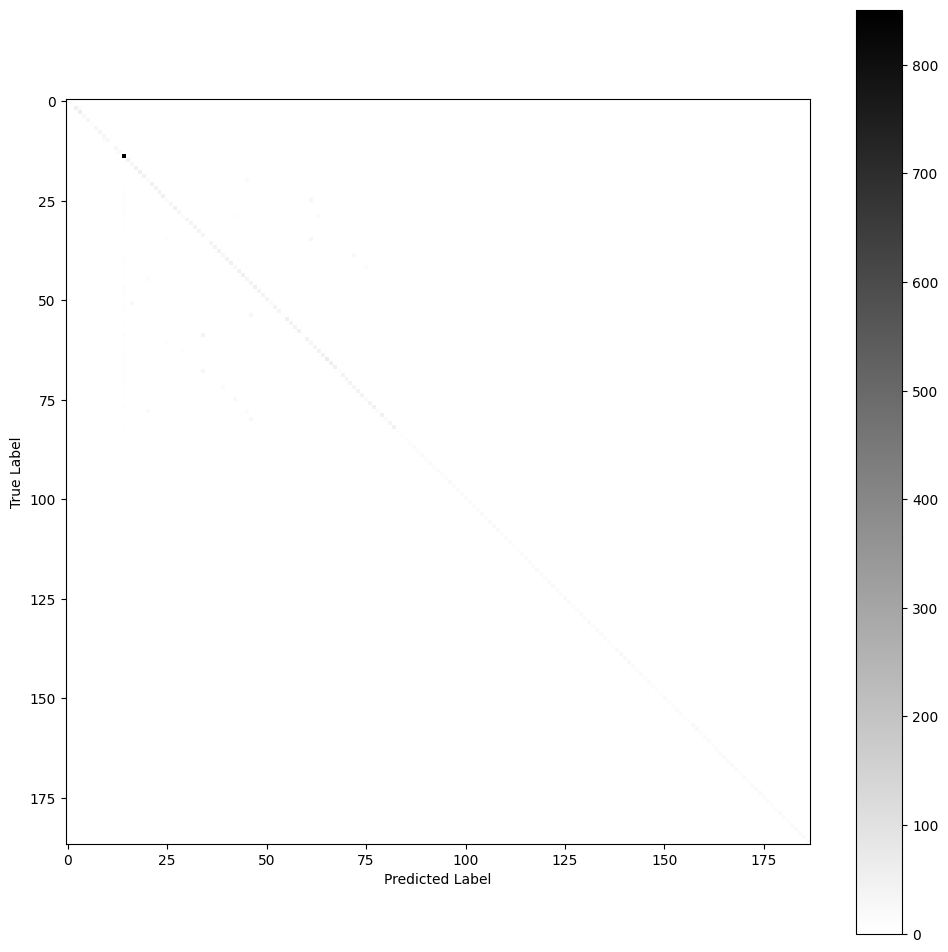

In [9]:
#AUC Metric for PyTorch Models
#from torcheval.metrics.aggregation.auc import AUC
#metric = AUC()

from sklearn.metrics import roc_auc_score
from torch.nn import Softmax

Soft_list = np.array([[]]).reshape((0,187))
values_list = np.array([])
pred_list = np.array([])

with torch.no_grad():
   model.eval()
   model.to(device)
   for data in test_loader:
       data = data.to(device)
       out = model(data.x, data.edge_index, data.batch)
       pred= out.argmax(dim=1)
       softmax = Softmax()
       softout = softmax(out)
       y = data.y
       Soft_list = np.concatenate((Soft_list, softout.cpu().numpy()), axis=0)
       pred_list = np.concatenate((pred_list, pred.cpu().numpy()), axis=0)
       # print(Soft_list)
       values_list= np.concatenate((values_list, y.cpu().numpy()), axis=None)
  # print(out)
  # print('*'*888)
  # print(softout)
  # print('*'*888)
print(Soft_list)
print(Soft_list.shape)
print(values_list)
print(values_list.shape)
print(pred_list)
print(pred_list.shape)

print("The Area Under ROC Curve (AUC) =", roc_auc_score(values_list, Soft_list, multi_class='ovr'))

from sklearn.metrics import f1_score
print("F1 Score =", f1_score(values_list, pred_list, average = 'macro'))

from sklearn.metrics import accuracy_score

print("Testing Accuracy =",accuracy_score(values_list, pred_list))

#Generates Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(values_list, pred_list)#, labels=classes
print(cm)

import matplotlib.pyplot as plt
# plt.imshow(cm, interpolation = 'none')
plt.rcParams['figure.figsize'] = (12, 12)
# plt.figure(figsize=(25, 25))
plt.imshow(cm, interpolation = 'none', cmap = 'binary')
# plt.imshow(cm, interpolation = 'none', cmap = 'cividis')

plt.colorbar()

# plt.title('Matrix Visualization')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.plot()


#Saves the model state
print(model.state_dict())
torch.save(model.state_dict(), 'model_342_finishtraininglater.pt')
